# Building GoogleNet on Tensorflow
GoogleNet is one of the most popular frameworks in Computer Vision. I'm going to learn this framework in detail and build the so-called *Inception* module from scratch.

## What Is GoogleNet?
But first, what is GoogleNet? GoogleNet was developed by Szegedy et al. from Google in 2014. This network was the state-of-the-art in image classification and detection, and has become a baseline framework of [Transfer Learning](https://en.wikipedia.org/wiki/Transfer_learning) for other research (e.g. [YOLO](https://arxiv.org/abs/1506.02640)). This network has been updated several times (I think currently about 4 times), but I use the first version, i.e. [this paper](https://arxiv.org/abs/1409.4842).

Based on the paper, this network has 22 layers (excluding pooling layer. Actually, this network looks very similar to [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf). The thing that makes this network special is the *Inception* module.

## Inception
Honestly, the first thing comes to my mind when I hear the word *inception* is the Inception movie.
<img src='inception_meme.jpg'>
I don't know whether the name *Inception* was inspired from this movie, but the main concept is similar: 'the need of going deeper'.

Let's begin with the idea of Inception. During network development, a question arises: **What is the size of kernel we need to use?** The simplest answer is to simply use all the kernel size in the network and let the network decides the best. That's the idea behind Inception. Quite simple, isn't it?

Actually, there are two kinds of Inception module. The first one is the **'naive' version** (see the image below taken from the paper).
<img src='naive.png'>
You can see that there are 3 convolutions with different kernel sizes and an additional maxpooling layer. The results are simply concatenated. The drawbacks of this method are too many parameters to be trained and too many calculation steps. It is understandable, since there are 3 different convolutions. Therefore, the second version, **reduction version** is used.
<img src='reduction.png'>
There are **1x1 convolutions** before the large convolutions (3x3 or 5x5). At first, I thought that the idea of 1x1 convolution was ridiculous: why do we need 1x1 convolution? Actually, this concept is very useful to reduce the number of filter. Say the input size is 28x28x128. If we use 64 convolutions with size 3x3, we need $3\times3\times128\times64=73,728$ parameters to be trained. However, if we use 1x1 convolutions beforehand (say we use 64 filters), then the number of trainable parameters is $1\times1\times128\times64+3\times3\times64\times64=45,056$, or 39% parameters reduction. Not bad, isn't it? Moreover, the similar idea is used in adding 1x1 convolution after maxpooling layer.

This is the basic idea of the Inception module. The full network architecture can be found in [the paper](https://arxiv.org/abs/1409.4842).

## Building ~~GoogleNet~~ Inception from Scratch
I'm not going to build GoogleNet from scratch (since the layers are too many!) But I'm going to build the inception module. Btw I use Tensorflow 1.4.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
tf.reset_default_graph()

Say the previous layer size is 28x28x128. I'll just create a placeholder for this.

In [2]:
prev_layer = tf.placeholder(dtype=tf.float32, shape=[None,28,28,128])

Let's create the 'naive' version first. Since the convolution results are concatenated, the output size has to be the same. Therefore, I use 'SAME' padding with stride 1x1. For every convolution size, I use 64 filters. The result size is pretty big: 320 filters.

In [3]:
with tf.variable_scope('naive'):
    naive_conv_1x1 = tf.layers.conv2d(inputs=prev_layer,filters=64,
                    kernel_size=[1,1], strides=(1,1), padding='SAME')
    naive_conv_3x3 = tf.layers.conv2d(inputs=prev_layer, filters=64,
                    kernel_size=[3,3], strides=(1,1), padding='SAME')
    naive_conv_5x5 = tf.layers.conv2d(inputs=prev_layer, filters=64,
                    kernel_size=[5,5], strides=(1,1), padding='SAME')
    naive_maxpool = tf.layers.max_pooling2d(inputs=prev_layer,
                    pool_size=[3,3], strides=(1,1), padding='SAME')
    naive_output = tf.concat([naive_conv_1x1, naive_conv_3x3,
                              naive_conv_5x5, naive_maxpool], axis=-1)
    print naive_output

Tensor("naive/concat:0", shape=(?, 28, 28, 320), dtype=float32)


The trainable variables are as follows:

In [4]:
tf.trainable_variables()

[<tf.Variable 'naive/conv2d/kernel:0' shape=(1, 1, 128, 64) dtype=float32_ref>,
 <tf.Variable 'naive/conv2d/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'naive/conv2d_1/kernel:0' shape=(3, 3, 128, 64) dtype=float32_ref>,
 <tf.Variable 'naive/conv2d_1/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'naive/conv2d_2/kernel:0' shape=(5, 5, 128, 64) dtype=float32_ref>,
 <tf.Variable 'naive/conv2d_2/bias:0' shape=(64,) dtype=float32_ref>]

Let's compare it with Reduction version. I will reduce the number filters in every convolution into 64. The result size is smaller since the dimension has been reducted by 1x1 convolution.

In [5]:
tf.reset_default_graph()
prev_layer = tf.placeholder(dtype=tf.float32, shape=[None,28,28,128])

In [6]:
with tf.variable_scope('reduction'):
    reduc_conv_1x1a = tf.layers.conv2d(inputs=prev_layer,filters=64,
                    kernel_size=[1,1], strides=(1,1), padding='SAME')
    
    reduc_conv_1x1b = tf.layers.conv2d(inputs=prev_layer,filters=64,
                    kernel_size=[1,1], strides=(1,1), padding='SAME')
    reduc_conv_3x3 = tf.layers.conv2d(inputs=reduc_conv_1x1b,
                        filters=64, kernel_size=[3,3],
                        strides=(1,1), padding='SAME')
    
    reduc_conv_1x1c = tf.layers.conv2d(inputs=prev_layer,filters=64,
                    kernel_size=[1,1], strides=(1,1), padding='SAME')
    reduc_conv_5x5 = tf.layers.conv2d(inputs=reduc_conv_1x1c,
                        filters=64, kernel_size=[5,5],
                        strides=(1,1), padding='SAME')
    
    reduc_maxpool = tf.layers.max_pooling2d(inputs=prev_layer,
                    pool_size=[3,3], strides=(1,1), padding='SAME')
    reduc_conv_1x1d = tf.layers.conv2d(inputs=reduc_maxpool, 
                        filters=64, kernel_size=[1,1],
                        strides=(1,1), padding='SAME')
    
    naive_output = tf.concat([reduc_conv_1x1a, reduc_conv_3x3,
                            reduc_conv_5x5, reduc_conv_1x1d], axis=-1)
    print naive_output

Tensor("reduction/concat:0", shape=(?, 28, 28, 256), dtype=float32)


The number of trainable variables is much smaller compared to the 'naive' version.

In [7]:
tf.trainable_variables()

[<tf.Variable 'reduction/conv2d/kernel:0' shape=(1, 1, 128, 64) dtype=float32_ref>,
 <tf.Variable 'reduction/conv2d/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'reduction/conv2d_1/kernel:0' shape=(1, 1, 128, 64) dtype=float32_ref>,
 <tf.Variable 'reduction/conv2d_1/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'reduction/conv2d_2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 <tf.Variable 'reduction/conv2d_2/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'reduction/conv2d_3/kernel:0' shape=(1, 1, 128, 64) dtype=float32_ref>,
 <tf.Variable 'reduction/conv2d_3/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'reduction/conv2d_4/kernel:0' shape=(5, 5, 64, 64) dtype=float32_ref>,
 <tf.Variable 'reduction/conv2d_4/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'reduction/conv2d_5/kernel:0' shape=(1, 1, 128, 64) dtype=float32_ref>,
 <tf.Variable 'reduction/conv2d_5/bias:0' shape=(64,) dtype=float32_ref>]

That's it. Simple enough, right? Just put this module into the network.

## Pre-trained GoogleNet
Fortunately, pretrained model for this network is available on Tensorflow.

In [8]:
tf.reset_default_graph()

Well, loading the pretrained model is not as easy as I thought previously. I thought below code will work, but it didn't! However, don't worry. I'll explain.

Basically, since the Keras model is different with Tensorflow, some adjustments have to be made. Using *tf.keras.applications.InceptionV3* will load the Keras model instance containing the network and the weights. By doing so, the graph is loaded in Tensorflow. However, the **weights** haven't been loaded. That's why if we use *tf.global_variables_initializer*, all weights will be initialized randomly. Of course, we don't want that.

In [9]:
# model = tf.keras.applications.InceptionV3()
# sess = tf.Session()
# sess.run(tf.global_variables_initializer())

Here's the method (inspired from great [post](https://github.com/zachmoshe/zachmoshe.com/blob/master/content/use-keras-models-with-tf/using-keras-models-in-tf.ipynb)). The idea is simply to save the weights as Tensorflow format and then load the weights. But before that, we need to get all the variables required for prediction, i.e. input, output, and the rest of the placeholders (such as learning_phase).

In [10]:
with tf.Session() as sess:
    # customize input shape
    image_input = tf.placeholder(name='image_input', dtype=tf.float32,
                                 shape=[None,299,299,3])
    # load keras model
    model = tf.keras.applications.InceptionV3(input_tensor=image_input)
    # get all the variables required for prediction
    learning_phase = tf.get_default_graph().get_tensor_by_name( \
                        'batch_normalization/keras_learning_phase:0')
    prediction = tf.argmax(model.output, -1)
    # get all the variables in the model
    weights =  tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    # save all the weights in TF format
    checkpoint = tf.train.Saver(weights).save(sess, 'model/variable')

The next we need to do is load the weights. Voila! The model is ready to use.

In [11]:
sess = tf.Session()
# loading the weights
tf.train.Saver(weights).restore(sess, checkpoint)

INFO:tensorflow:Restoring parameters from model/variable


Let's try to predict some images. First, I load the labels of the classes (taken from [here](https://github.com/zachmoshe/zachmoshe.com/blob/master/content/use-keras-models-with-tf/using-keras-models-in-tf.ipynb)). Then, I load and resize the images into *(299,299)*. The predictions below are correct.

In [12]:
labels = eval(open('imagenet_1000_classes.txt').read())

goldfish, Carassius auratus


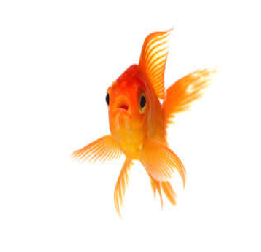

In [13]:
image = Image.open('goldfish.jpg')
image = image.resize(size=(299,299), resample=Image.BILINEAR)
image_arr = 1.0*np.array(image.getdata())/255
image_arr = image_arr.reshape(1,299,299,3)
plt.axis('off')
plt.imshow(image);
pred = sess.run(prediction, {image_input: image_arr,
                             learning_phase: 0})
print labels[pred[0]]

balloon


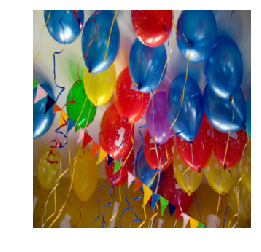

In [14]:
image = Image.open('balloon.jpg')
image = image.resize(size=(299,299), resample=Image.BILINEAR)
image_arr = 1.0*np.array(image.getdata())/255
image_arr = image_arr.reshape(1,299,299,3)
plt.axis('off')
plt.imshow(image);
pred = sess.run(prediction, {image_input: image_arr,
                             learning_phase: 0})
print labels[pred[0]]

Btw, if you want to see the full model, just use below code.

In [15]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 149, 149, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 149, 149, 32)  96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 149, 149, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

## Train Your Own GoogleNet
Since training image network from scratch is too costly, many researchers prefer to use pre-trained weights as the initial weights. One thing we need to do is to exclude the fully connected layers and add your own fully connected layers. Say we want to classify 100 classes. You can try below code.

In [16]:
tf.reset_default_graph()

In [17]:
with tf.Session() as sess:
    # customize input shape
    image_input = tf.placeholder(name='image_input', dtype=tf.float32,
                                 shape=[None,299,299,3])
    # load keras model
    # exclude top fully connected layer
    # use avg-pooling before fully connected
    model = tf.keras.applications.InceptionV3(input_tensor=image_input,
                                    include_top=False, pooling='avg')
    # get all the variables required for prediction
    learning_phase = tf.get_default_graph().get_tensor_by_name( \
                        'batch_normalization/keras_learning_phase:0')
    output = tf.layers.dense(inputs=model.output, units=100,
                             activation=tf.nn.softmax, name='output')
    predict = tf.argmax(output, -1, name='predict')
    # initialize the newly added variables
    sess.run(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)[-2] \
             .initializer)
    sess.run(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)[-1] \
             .initializer)
    # get all the variables in the model
    weights =  tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    # save all the weights in TF format
    checkpoint = tf.train.Saver(weights).save(sess, 'model/variable')

## Conclusion
GoogleNet is a very nice baseline framework to solve our task. The pre-trained model is readily available and very easy to use.

That's all. Your feedback is very welcomed :)